### LIBRARIES
This code loads essential PyTorch tools for building and training neural networks, processing images, and visualizing data. It also uses pandas, numpy, and sklearn to handle and analyze data easily.

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision 
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

### PATH
PATH holds the location of the dataset folder for rice images used in your work.

In [2]:
PATH = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# TRANSFORMERS
This code sets up a series of image transformations: converts images to tensors, resizes them to 250x250 pixels, and normalizes pixel values for consistent input to a model.

In [3]:
#
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((250,250)),
    transforms.Normalize((0.5,0.5,0.5),(0.45,0.45,0.45))
])

# IMAGEFOLDER
This line creates a dataset from images in the folder specified by PATH, applying the transformations defined earlier (like resizing and normalization) to each image.

In [4]:
data = torchvision.datasets.ImageFolder(root = PATH, transform = transform)

# CLASSES
This command prints the list of class names (categories) found in the dataset. It helps you see what labels the images are sorted into.

In [5]:
print(data.classes)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


# DISPLAY
This code defines a function to display an image and its label. It prints the label and shows the image using Matplotlib. data[100] fetches the 100th image from the dataset to be displayed.

label: (tensor([[[-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         ...,
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111]],

        [[-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         ...,
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111]],

        [[-1.1111, -1.1111, -1.1111,  ..., -1.1111, -1.1111, -1.1111],
         [-1.1111, -1.1111, -1.1111, 

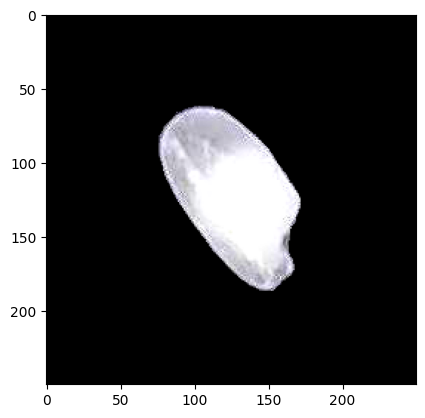

In [6]:
def display_img(img, label):
    print(f'label: {data[label]}')
    plt.imshow(img.permute(1,2,0))

display_img(*data[100])

# SHAPE
This code fetches the image and label at index 800 from the dataset. It prints the shape of the image tensor and its corresponding label.

In [7]:
images, labels = data[800]
print('shape:',images.shape, 'label:', labels)

shape: torch.Size([3, 250, 250]) label: 0


# SPLITING DATA
This code splits the dataset into training, validation, and test sets. It shuffles the dataset, determines the split sizes, and creates samplers and data loaders for each subset to facilitate training and evaluation.

In [8]:
# Get the total number of data points in the dataset
dataset_size = len(data)
# Create a list of indices (0, 1, 2, ..., dataset_size-1)
indices = list(range(dataset_size))

# Shuffle the indices randomly to ensure random selection
np.random.shuffle(indices)

# Calculate the index at which to split the data for validation and testing
val_split_index = int(np.floor(0.2 * dataset_size))
test_split_index = int(np.floor(0.1 * dataset_size))


# Split the indices into test, validation, and training sets
test_idx = indices[:test_split_index]
val_idx = indices[test_split_index:test_split_index + val_split_index]
train_idx = indices[test_split_index + val_split_index:]

# Print the number of samples in each set
print(len(train_idx), len(val_idx), len(test_idx))

# Create samplers for each dataset split
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Create DataLoader objects for each dataset split with a batch size of 100
train_loader = DataLoader(dataset = data, batch_size = 100, sampler = train_sampler)
val_loader = DataLoader(dataset = data, batch_size = 100, sampler = val_sampler)
test_loader = DataLoader(dataset = data, batch_size = 100, sampler = test_sampler)

52500 15000 7500


# DISPLAY
This function displays a batch of images from a data loader. It creates a grid of images from the batch and shows it using Matplotlib, with no axis ticks for a cleaner look.

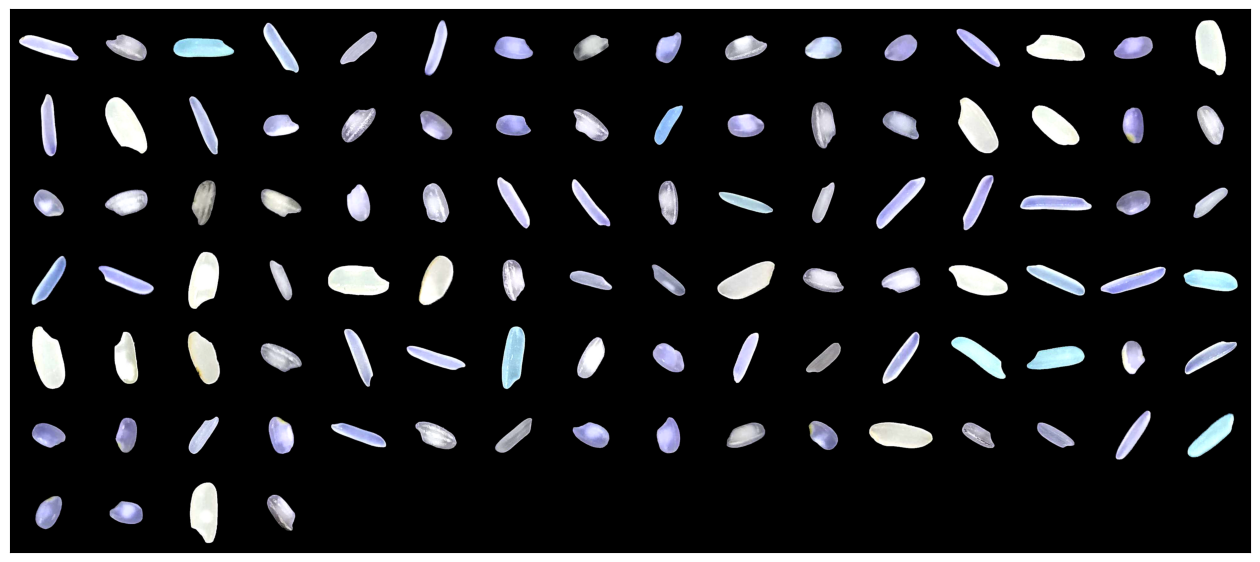

In [9]:
#Showing content of a single batch 
def show_batch(dl):
    for images, label in dl:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

show_batch(train_loader)

# GPU or CPU
This line sets the computing device to GPU if available (using CUDA), otherwise, it defaults to CPU. This helps in utilizing hardware acceleration for faster computations.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# MODEL
This code defines a Convolutional Neural Network (CNN) class named CNN_RICE for image classification. It includes convolutional layers for feature extraction and fully connected layers for classification. The model is then moved to the specified device (GPU or CPU).

In [11]:
class CNN_RICE(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the convolutional layers and activation functions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 3, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 1 ),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
        )
        # Define the fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(in_features = 64 * 10 * 10, out_features = 3200),
            nn.ReLU(),
            nn.Linear(in_features = 3200, out_features =5),
        )

    def forward(self, X):
        X = self.conv(X)
        X = X.view(X.size(0), -1)
        X = self.fc(X)

        return X

model = CNN_RICE().to(device)

# OPTIMIZATION AND LOSS FUNCTION
This code sets up the loss function and optimizer for training a neural network. nn.CrossEntropyLoss() is used to measure prediction errors for classification, while optim.SGD() is an optimizer that updates the model's parameters using stochastic gradient descent with a learning rate of 0.01.

In [12]:
#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# TRAIN
This code trains a neural network for 5 epochs. It calculates and stores the training loss and validation accuracy for each epoch. The network is updated using backpropagation and evaluated on the validation set.

In [13]:
# Lists to store loss and accuracy for each epoch
losses_list = []
accuracy_list = []

# Number of epochs to train the model
epochs = 5

# Training loop
for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    epoch_loss = 0

    # Iterate over the training data
    for images, labels in train_loader:
        # Move data to the device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass: compute model predictions
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Zero the gradients from the previous step
        optimizer.zero_grad()
        
        # Backward pass: compute the gradients
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Accumulate loss for this epoch
        epoch_loss += loss.item() 

    # Calculate average loss for this epoch and store it
    losses_list.append(epoch_loss / len(train_loader))

    # Validation loop
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for validation
        for images, labels in val_loader:
            # Move data to the device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass: compute model predictions
            outputs = model(images)
            
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)
            
            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy and store it
    accuracy = correct / total
    accuracy_list.append(accuracy)

    # Print the results for this epoch
    print('Epoch:[{}][{}] training Loss{:.4f} Validation Accuracy: {:.4f}'.format(epoch+1, epochs, losses_list[-1], accuracy))


Epoch:[1][5] training Loss0.6668 Validation Accuracy: 0.9464
Epoch:[2][5] training Loss0.1847 Validation Accuracy: 0.9685
Epoch:[3][5] training Loss0.1176 Validation Accuracy: 0.9623
Epoch:[4][5] training Loss0.1005 Validation Accuracy: 0.9725
Epoch:[5][5] training Loss0.0932 Validation Accuracy: 0.9718


# SAVE MODEL 
This code saves the model's state (weights) and the optimizer's state to a file named rice_CNN.pth. This allows you to later reload the model and optimizer to resume training or perform inference.

In [14]:
save_state = {
    'model': model.state_dict(),
    'optimizer' : optimizer.state_dict()
}
torch.save(save_state, 'rice_CNN.pth')

# TESTING THE MODEL
This code evaluates the trained model on the test dataset. It calculates the accuracy by comparing the model's predictions to the true labels and then prints the test accuracy.

In [15]:
# Checking the accuracy with the test dataset
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy: {:.4f}'.format(correct/total))

Test Accuracy: 0.9715


# PRECISION RECALL AND ACCURACY
his code checks the precision, recall, and accuracy of the model on the test dataset using the classification_report function from sklearn. It converts predictions and true labels from tensors to NumPy arrays and then prints a detailed report showing these metrics for each class.

In [16]:
# Checking for precision, recall and accuracy test dataset
y_pred = predicted.to('cpu')
y_pred = y_pred.numpy()

y_true = labels.to('cpu')
y_true = y_true.numpy()

print(classification_report(y_true, y_pred, target_names = data.classes))

              precision    recall  f1-score   support

     Arborio       1.00      0.94      0.97        17
     Basmati       0.96      0.96      0.96        26
      Ipsala       1.00      1.00      1.00        19
     Jasmine       0.95      0.95      0.95        21
   Karacadag       0.94      1.00      0.97        17

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

